# Business Case: Automobile Industry

Agustín Giménez

From 365-Careers Time-Series Analysis course offered through www.udemy.com

## Importing the Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [2]:
# import library
import yfinance

# scrape data from yahoo finance
raw_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval="1d", group_by='ticker',
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [3]:
# create dataframe
df = raw_data.copy()

In [4]:
df.head()

PAH3.DE                          BMW.DE                      \
              Open High Low Close Volume      Open      High       Low   
Date                                                                     
1996-11-08     NaN  NaN NaN   NaN    NaN  9.353780  9.353780  9.333748   
1996-11-11     NaN  NaN NaN   NaN    NaN  9.343506  9.348643  9.288031   
1996-11-12     NaN  NaN NaN   NaN    NaN  9.328608  9.414389  9.293165   
1996-11-13     NaN  NaN NaN   NaN    NaN  9.422613  9.422613  9.343510   
1996-11-14     NaN  NaN NaN   NaN    NaN  9.351211  9.394359  9.313714   

                                VOW3.DE                        
               Close     Volume    Open High Low Close Volume  
Date                                                           
1996-11-08  9.333748   767000.0     NaN  NaN NaN   NaN    NaN  
1996-11-11  9.308577   260000.0     NaN  NaN NaN   NaN    NaN  
1996-11-12  9.378947  1066000.0     NaN  NaN NaN   NaN    NaN  
1996-11-13  9.364056   793000.0     NaN  NaN NaN   NaN    NaN  
1996-11-14  9.394359   351000.0     NaN  NaN NaN   NaN    NaN

## Defining Key Dates

In [5]:
# Starting Date
start_date = '2009-04-05'

# First Official Announcement - VW purchases 49.9% of Porsche
ann_1 = '2009-12-09'

# Second Official Announcement - VW purchases remaining 51.1% of Porsche
ann_2 = '2012-07-05'

#Ending Date
end_date = '2014-01-01'

# Dieselgate
d_gate = '2015-09-20'

## Pre-processing the Data

In [6]:
# Extracting Closing Prices
df['vw'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vw'] = df['vw'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sqr_vw'] = df['ret_vw'].mul(df.ret_vw)
df['sqr_por'] = df['ret_por'].mul(df.ret_por)
df['sqr_bmw'] = df['ret_bmw'].mul(df.ret_bmw)

# Extracting Volume
df['vol_vw'] = df['VOW3.DE'].Volume
df['vol_por'] = df['PAH3.DE'].Volume
df['vol_bmw'] = df['BMW.DE'].Volume

In [7]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method = 'bfill')

In [8]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

#### We will not split the data into training and testing set in this exercise, since our goals is not to forecast values into the future.

## Plotting the Prices

<AxesSubplot:xlabel='Date'>

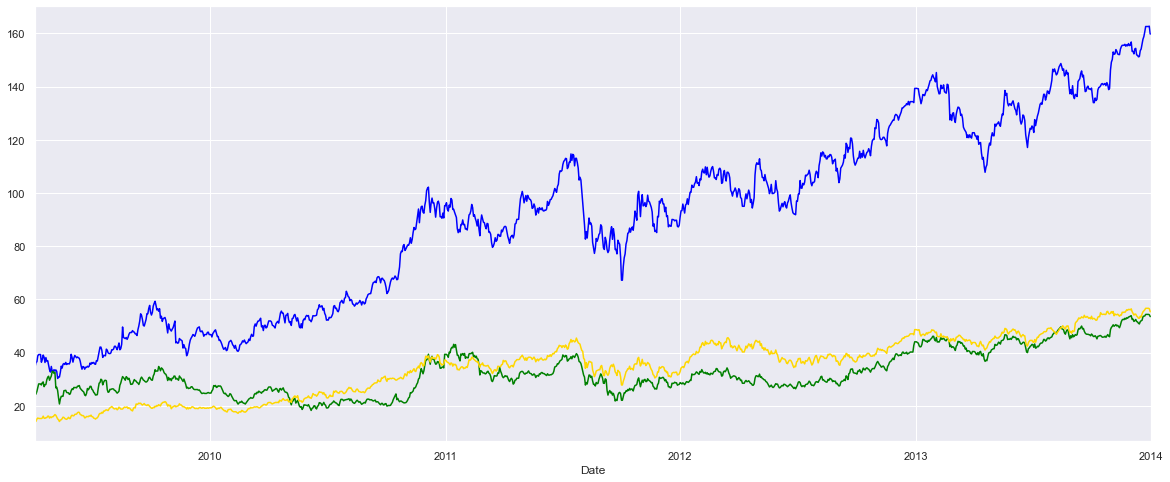

In [9]:
df['vw'][start_date:end_date].plot(figsize=(20,8), color="blue")
df['por'][start_date:end_date].plot(figsize=(20,8), color="green")
df['bmw'][start_date:end_date].plot(figsize=(20,8), color="gold")

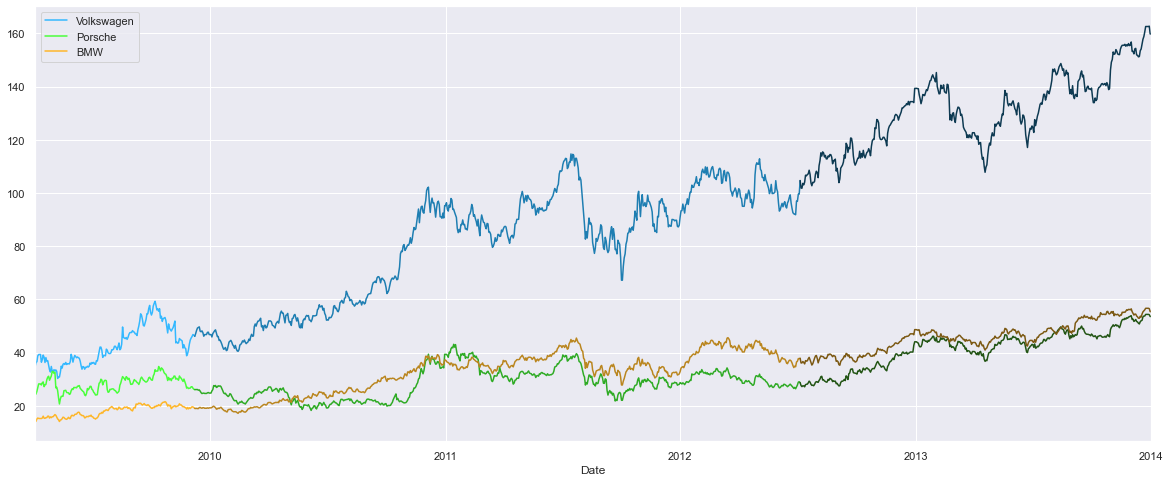

In [10]:
# Shades of Blue:
#color = "#33B8FF"
#color = "#1E7EB2"
#color = "#0E3A52"

# Shades of Green:
#color = "#49FF3A"
#color = "#2FAB25"
#color = "#225414"

# Shades of Gold:
#color = "#FEB628"
#color = "#BA861F"
#color = "#7C5913"


df['vw'][start_date:ann_1].plot(figsize=(20,8), color="#33B8FF")
df['por'][start_date:ann_1].plot(figsize=(20,8), color="#49FF3A")
df['bmw'][start_date:ann_1].plot(figsize=(20,8), color="#FEB628")

df['vw'][ann_1:ann_2].plot(figsize=(20,8), color="#1E7EB2")
df['por'][ann_1:ann_2].plot(figsize=(20,8), color="#2FAB25")
df['bmw'][ann_1:ann_2].plot(figsize=(20,8), color="#BA861F")

df['vw'][ann_2:end_date].plot(figsize=(20,8), color="#0E3A52")
df['por'][ann_2:end_date].plot(figsize=(20,8), color="#225414")
df['bmw'][ann_2:end_date].plot(figsize=(20,8), color="#7C5913")

plt.legend(['Volkswagen', 'Porsche', 'BMW'])


## Correlation

In [11]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vw'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vw'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8359546964837994
Volkswagen and BMW correlation: 	0.9799378254996481
Porsche and BMW correlation: 		0.8052157785388847


VW is a market benchmark.

In [12]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vw'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t'+ str(df['vw'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633585092907462
Volkswagen and BMW correlation: 	0.8427608560302483
Porsche and BMW correlation: 		0.6095040423780957


In [13]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vw'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vw'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428268018604895
Volkswagen and BMW correlation: 	0.9795942964604551
Porsche and BMW correlation: 		0.7042723396115652


In [14]:
print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vw'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vw'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.9405237051109556
Volkswagen and BMW correlation: 	0.9284447477867839
Porsche and BMW correlation: 		0.9494111477639376


In [15]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vw'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW correlation: \t'+ str(df['vw'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2022-07-04 00:00:00

Volkswagen and Porsche correlation: 	0.8993996268057576
Volkswagen and BMW correlation: 	0.6908381649371735
Porsche and BMW correlation: 		0.7796091061026091


We can see that correlation between VW and the other manufacturers is diminished after the Dieselgate scandal.

## Best Fitting Models

### For Volkswagen

In [16]:
# Pre- 1st Announcement
mod_pr_pre_vw = auto_arima(df.vw[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)

# Pre- 2nd Announcement
mod_pr_btn_vw = auto_arima(df.vw[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)

# Post 2nd Announcement
mod_pr_post_vw = auto_arima(df.vw[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

# Note
# m: The period for seasonal differencing, m refers to the number of periods in each season.

In [17]:
# summary
mod_pr_pre_vw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -313.553
Date:                Mon, 04 Jul 2022   AIC                            637.106
Time:                        09:45:28   BIC                            653.015
Sample:                    04-06-2009   HQIC                           643.557
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6858      0.424      1.618      0.106      -0.145       1.517
por            0.3925      0.094      4.169      0.000       0.208       0.577
bmw            0.7059      0.335      2.107      0.035       0.049       1.363
ar.L1          0.9633      0.020     48.670      0.000       0.925       1.002
sigma2         1.9550      0.133     14.718      0.000       1.695       2.215
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):               166.03
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
mod_pr_btn_vw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1044.484
Date:                Mon, 04 Jul 2022   AIC                           2094.968
Time:                        09:45:28   BIC                           2108.495
Sample:                    12-09-2009   HQIC                          2100.207
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7760      0.060     12.842      0.000       0.658       0.894
bmw            1.5801      0.074     21.269      0.000       1.435       1.726
sigma2         1.3170      0.054     24.532      0.000       1.212       1.422
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               112.41
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
mod_pr_post_vw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -587.155
Date:                Mon, 04 Jul 2022   AIC                           1180.310
Time:                        09:45:28   BIC                           1192.201
Sample:                    07-05-2012   HQIC                          1185.024
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.6868      0.056     30.369      0.000       1.578       1.796
bmw            0.8749      0.093      9.381      0.000       0.692       1.058
sigma2         1.1983      0.059     20.461      0.000       1.084       1.313
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               103.80
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For Porsche

In [20]:
# Pre- 1st Announcement
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vw','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)

# Pre- 2nd Announcement
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vw','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)

# Post 2nd Announcement
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vw','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [21]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -219.737
Date:                Mon, 04 Jul 2022   AIC                            451.474
Time:                        09:45:56   BIC                            470.564
Sample:                    04-06-2009   HQIC                           459.215
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5562      0.363      1.533      0.125      -0.155       1.267
vw             0.1172      0.054      2.157      0.031       0.011       0.224
bmw            0.9170      0.165      5.558      0.000       0.594       1.240
ar.L1          1.0748      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.6837      0.048     14.098      0.000       0.589       0.779
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               559.39
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -558.076
Date:                Mon, 04 Jul 2022   AIC                           1126.153
Time:                        09:45:56   BIC                           1148.696
Sample:                    12-09-2009   HQIC                          1134.884
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vw             0.1819      0.016     11.134      0.000       0.150       0.214
bmw            0.3449      0.048      7.200      0.000       0.251       0.439
ar.L1          0.6585      0.230      2.860      0.004       0.207       1.110
ma.L1         -0.5897      0.246     -2.394      0.017      -1.073      -0.107
sigma2         0.3090      0.010     32.415      0.000       0.290       0.328
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1076.52
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -196.988
Date:                             Mon, 04 Jul 2022   AIC                            401.976
Time:                                     09:45:56   BIC                            417.831
Sample:                                 07-05-2012   HQIC                           408.262
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vw             0.2261      0.013     16.876      0.000       0.200       0.252
bmw            0.2604      0.043      6.036      0.000       0.176       0.345
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1612      0.006     27.851      0.000       0.150       0.173
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               613.59
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the Future

### For Volkswagen

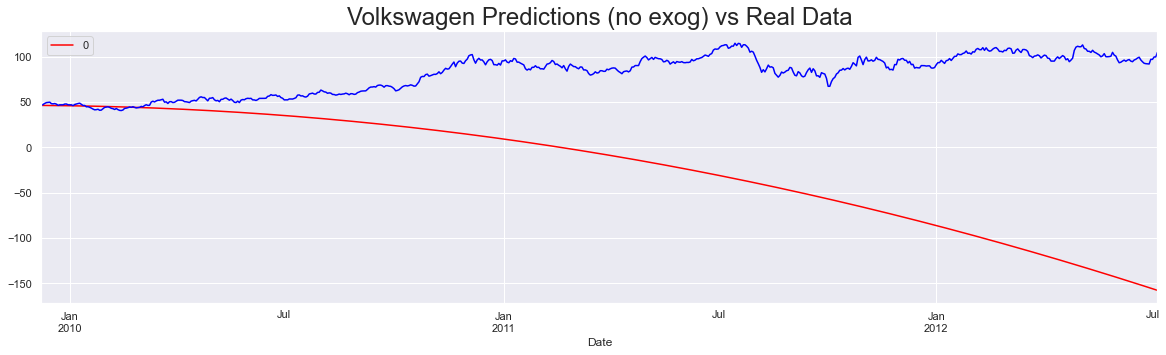

In [31]:
# New Pre- 1st Announcement Model
model_auto_pred_vw = auto_arima(df.vw[start_date:ann_1],m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q=5, trend="ct")

# Predictions
df_auto_pred_vw = pd.DataFrame(model_auto_pred_vw.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)

# Plot
df_auto_pred_vw[ann_1:ann_2].plot(figsize=(20,5), color="red")
df.vw[ann_1:ann_2].plot(color="blue")
plt.title("Volkswagen Predictions (no exog) vs Real Data", size=24)
plt.show()

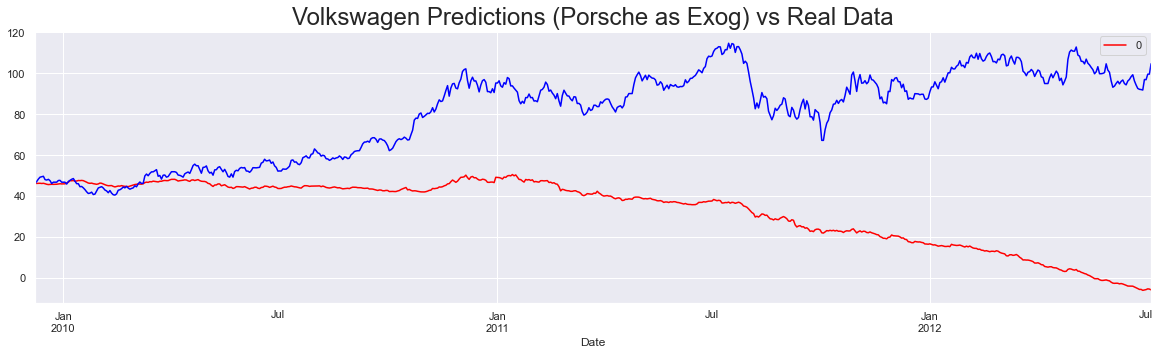

In [35]:
# New Pre- 1st Announcement Model
model_auto_pred_vw_2 = auto_arima(df.vw[start_date:ann_1], exogenous=df[["por"]][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q=5, trend="ct")

# Predictions
df_auto_pred_vw_2 = pd.DataFrame(model_auto_pred_vw_2.predict(n_periods = len(df[ann_1:ann_2]),
                                                              exogenous=df[["por"]][ann_1:ann_2])
                                 , index = df[ann_1:ann_2].index)

# Plot
df_auto_pred_vw_2[ann_1:ann_2].plot(figsize=(20,5), color="red")
df.vw[ann_1:ann_2].plot(color="blue")
plt.title("Volkswagen Predictions (Porsche as Exog) vs Real Data", size=24)
plt.show()

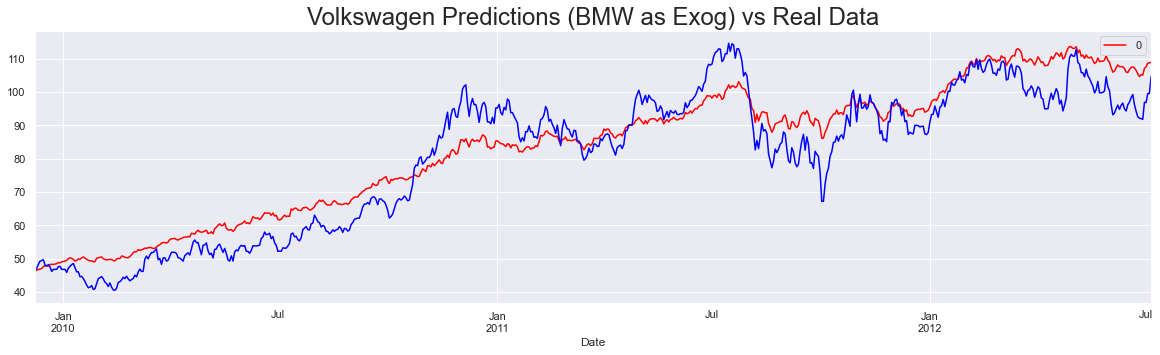

In [36]:
# New Pre- 1st Announcement Model
model_auto_pred_vw_3 = auto_arima(df.vw[start_date:ann_1], exogenous=df[["bmw"]][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q=5, trend="ct")

# Predictions
df_auto_pred_vw_3 = pd.DataFrame(model_auto_pred_vw_3.predict(n_periods = len(df[ann_1:ann_2]),
                                                              exogenous=df[["bmw"]][ann_1:ann_2])
                                 , index = df[ann_1:ann_2].index)

# Plot
df_auto_pred_vw_3[ann_1:ann_2].plot(figsize=(20,5), color="red")
df.vw[ann_1:ann_2].plot(color="blue")
plt.title("Volkswagen Predictions (BMW as Exog) vs Real Data", size=24)
plt.show()

#### Remember that $prediction \ne forecast$ !!

## Volatility

### Volatility of VW for Each Period

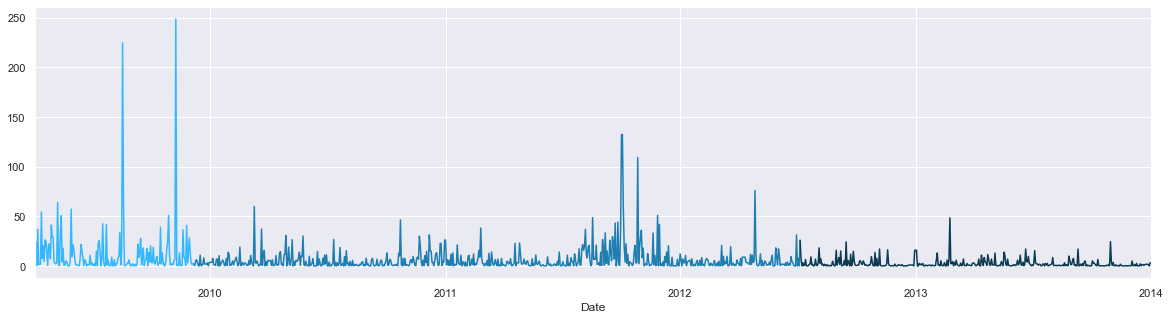

In [39]:
# Plot
df['sqr_vw'][start_date:ann_1].plot(figsize=(20,5), color="#33B8FF")
df['sqr_vw'][ann_1:ann_2].plot(figsize=(20,5), color="#1E7EB2")
df['sqr_vw'][ann_2:end_date].plot(figsize=(20,5), color="#0E3A52")
plt.show()

We see that VW has highest volatility before any announcement. Such behaviour can most certainly be attributed to the rumours spreaading across the market about a deal in the horizon.

### Volatility Trends for Each Period using GARCH(1,1)

Reminder $GARCH(1,1): Var(y_{t}|y_{t-1})=\sigma_{t}^{2}=\Omega+\alpha_{1}\epsilon_{t-1}^{2}+\beta_{1}\sigma_{t-1}^{2}$

In [40]:
# Model Pre 1st Announcement
model_garch_pre = arch_model(df.ret_vw[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

# Model Pre 2nd Announcement
model_garch_btn = arch_model(df.ret_vw[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

# Model Post Announcements
model_garch_post = arch_model(df.ret_vw[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.7775471463415
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.00315646711425
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.99050551032326
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.99050545803095
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.7533496737337
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.7314182709051
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.7314182696596
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5622860434501
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5579431282397
            Iterations: 7
          

In [41]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 ret_vw   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.991
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Mon, Jul 04 2022   Df Residuals:                      177
Time:                        10:08:23   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6196      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.195e-02      1.675  9.399e-02 [-2.623e-02,  0.334]
beta[1]    2.0398e-12      0.349  5.841e-12      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [42]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 ret_vw   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Mon, Jul 04 2022   Df Residuals:                      671
Time:                        10:08:23   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.884      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [43]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 ret_vw   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Mon, Jul 04 2022   Df Residuals:                      389
Time:                        10:08:23   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""

In the third table, we see non significant coefficients for the constant $\Omega$ and for $\alpha_{1}$. This implies that there is some autocorrelation in volatility which fits the volatility clustering feature.

#### Overall, we see really different volatility trends in all three periods.